## Temat:  
### “Fajnie byłoby rozszerzyć nasz serwis o generowanie popularnych playlist – zestawów  pasujących do siebie utworów, których słuchaniem zainteresowane będzie wiele osób”

## Problem biznesowy:
Utworzenie przynajmniej 20 playlist które będą zawierały grupy podobnych utworów o wysokim stopniu popularności w okresie zeszłego tygodnia. Wygenerowane playlisty będą jednakowe dla wszystkich użytkowników.

### Zadania modelowania:
- Określenie stopnia popularności przez rankingowanie utworów na podstawie wskaźnika popularności utworu oraz liczby odtworzeń utworu w sesji użytkowników z okresu jednego tygodnia.
- Tworzenie playlist przez zadanie grupowania utworów podobnych do siebie na podstawie wykonawcy, gatunków w jakich tworzą swoje utwory oraz na podstawie metadanych.

### Założenia:
- playlista składa się z utworów, których łączny czas trwania wynosi co najmniej 1h
- popularne utwory to takie, które posiadają stopień popularności powyżej 75% wszystkich
- bierzemy pod uwagę w modelowaniu popularnych utworów sesję z zeszłego tygodnia

### Kryteria sukcesu:
- biznesowe:
    - Utworzenie co najmniej 20 playlist z popularnymi utworami. Co tydzień będą generowane nowe playlisty.

- analityczne:
    - Przed wdrożeniem porównać predykcje playlist z sesjami użytkowników i sprawdzić czy faktycznie ludzie w ostatnim tygodniu słuchali najwięcej utworów zawartych w playlistach
    - Po wdrożeniu sprawdzenie czy użytkownicy korzystają z utworzonych playlist przez analizę. Czy i w jakim stopniu kolejność odtwarzanych utworów w danej sesji użytkownika pokrywa się z utworami z którejś playlist. 

## Dane wejściowe

Jednorazowo i przy każdej zmianie:
- artyści
- utwory

Raz w tygodniu dane z zeszłego tygodnia:
- sesja użytkowników

# Funkcja celu

- Rankingowanie: Lista utworów które posiadają stopień popularności powyżej 75 %, które są wyznaczane na podstawie sesji użytkowników z poprzedniego tygodnia oraz wskaźnika popularności utworów.

- Grupowanie: Klastry zawierające podobne utwory o łącznej długości ok. jednej godziny. Utwory będą rozdzielane za pomocą wykonawcy, gatunków w jakich tworzą swoje utwory oraz na podstawie metadanych.



# Analiza danych

In [1]:
import pandas as pd
import json
import numpy as np

In [2]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav1/artists.jsonl")
sessions = jsonl2df("datav1/sessions.jsonl")
tracks = jsonl2df("datav1/tracks.jsonl")
users = jsonl2df("datav1/users.jsonl")

In [3]:
def get_nulls(df):
    for column in df.columns:
        nan_count = df[column].isna().sum()
        if nan_count:
            print(f'Number of NaN in column {column}: {nan_count}')

## Wykonawcy

In [4]:
artists.head()

,id,name,genres
0,7jVv8c5Fj3E9VhNjxT4snq,Lil Nas X,"[country rap, lgbtq+ hip hop, pop rap, queer c..."
1,0xRXCcSX89eobfrshSVdyu,MEDUZA,"[dance pop, edm, pop dance, pop house, tropica..."
2,3OKg7YbOIatODzkRIbLJR4,TheFatRat,[speedrun]
3,4f7KfxeHq9BiylGmyXepGt,Tanishk Bagchi,"[desi pop, filmi, modern bollywood]"
4,56mfhUDKa1vec6rSLZV5Eg,Jawsh 685,[nz pop]


In [5]:
artists.describe()

,id,name,genres
count,1667,1667,1590
unique,1577,1667,1296
top,-1,BEAM,"[latin, latin hip hop, reggaeton, reggaeton fl..."
freq,91,1,15


91 wartości w id przyjmują tą samą wartość -1 co nie pozwala na jednoznaczne przypisanie później wykonawcy do utworu. Są to jednak dane potrzebne ze względu na późniejsze rekomendacje utworu wraz z wykonawcą. Każdy użytkownik wolałby jednak to wiedzieć.

In [6]:
get_nulls(artists)

Number of NaN in column genres: 77


77 wierszy wykonawców nie posiada gatunku

In [7]:
artists["id"].value_counts().loc[lambda x: x > 1]

id
-1    91
Name: count, dtype: int64

# Utwory

In [8]:
tracks.head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55.0,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.332,0.713,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54.0,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.321,0.134,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,NaN,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.156,0.169,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54.0,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.788,0.590,126.974
4,6kD1SNGPkfX9LwaGd1FG92,None,53.0,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.152,0.100,90.150


In [9]:
tracks.describe(include=np.object_)

,id,name,id_artist,release_date
count,21274,21294,21278,22412
unique,21274,17000,1414,3907
top,27Y1N4Q4U3EfDU5Ubw8ws2,Runaway,06HL4z0CvFAxyc27GXpf02,2013-01-01
freq,1,10,292,268


Istnieją utwory które mają tą samą nazwę ale każdy z nich posiada unikalne id więc będzie można je zidentyfikować.

In [10]:
tracks.describe(include=np.number)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,21358.000000,2.241200e+04,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000,22412.000000
mean,61.407014,2.301383e+05,0.166607,0.599096,0.648017,5.278824,-7.196227,0.082914,0.267758,0.040220,0.193141,0.518000,121.911945
std,8.063279,7.209562e+04,0.372633,0.158259,0.209577,3.558813,3.738098,0.089317,0.276111,0.152828,0.167943,0.244477,29.615254
min,51.000000,3.062200e+04,0.000000,0.000000,0.000103,0.000000,-44.410000,0.000000,0.000001,0.000000,0.012000,0.000000,0.000000
25%,55.000000,1.914930e+05,0.000000,0.495000,0.508000,2.000000,-8.614500,0.033900,0.029800,0.000000,0.094400,0.325000,97.988000
50%,60.000000,2.206670e+05,0.000000,0.608000,0.672000,5.000000,-6.393000,0.046300,0.165000,0.000003,0.125000,0.512000,120.041000
75%,67.000000,2.562400e+05,0.000000,0.715000,0.816000,8.000000,-4.850000,0.086000,0.455000,0.000523,0.240000,0.713000,140.078000
max,99.000000,4.120258e+06,1.000000,0.980000,0.999000,11.000000,0.642000,0.944000,0.996000,0.998000,0.997000,0.991000,220.099000


## Analiza długości utworu

In [11]:
tracks.sort_values("duration_ms", ascending=False).head()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
13345,1saXdvEAafdRzUphXBzSHg,Ocean Waves for Sleep,56.0,4120258,0,2CgVSpL4tfbUuHmTGS7wF3,2010-07-16,0.0797,0.995,1,-17.379,0.0612,0.9320,0.5620,0.3100,0.00001,84.788
620,None,Atom Heart Mother,51.0,1421455,0,0k17h0D3J5VfsdmQ1iZtE9,1970-10-05,0.2660,0.216,9,-16.001,0.0333,0.7850,0.8850,0.0807,0.09190,137.558
12802,None,Echoes - 2011 Remastered Version,55.0,1412451,0,0k17h0D3J5VfsdmQ1iZtE9,1971-11-05,0.2850,0.322,6,-16.580,0.0440,0.3660,0.6510,0.1070,0.14200,134.042
675,7kriFJLY2KOhw5en9iI2jb,Echoes,58.0,1412451,0,0k17h0D3J5VfsdmQ1iZtE9,1971-11-11,0.2850,0.322,6,-16.580,0.0440,0.3660,0.6510,0.1070,0.14200,134.042
1162,5H8xFHau0x3PI1CssO6EaX,2112: Overture / The Temples Of Syrinx / Disco...,53.0,1233667,0,2Hkut4rAAyrQxRdof7FVJq,1976-04-01,0.3440,0.790,2,-7.456,0.0983,0.0823,0.0017,0.1870,0.20200,133.186


Czas mocno odstaje od reszty dla id 1saXdvEAafdRzUphXBzSHg i wynosi ponad 1h. Utwory zaraz za tym również mają wysokie wartości, bo wynoszą aż 20 pare minut. Pytanie czy to są już playlisty same w sobie, czy zapętlenia, czy też coś innego?

## Analiza głośności utworu

In [12]:
tracks[tracks["loudness"] > 0]

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
7302,5Ve4qBYAThGLTOva0hhoTa,So Bad,NaN,325347,1,7dGJo4pcD2V6oG8kP0tJRR,2010-06-18,0.773,0.811,1,0.496,0.0882,0.3040,0.0,0.174,0.774,81.037
11715,5PVv4YALJruehQKyAlwjfE,Must Be The Ganja,56.0,242907,1,7dGJo4pcD2V6oG8kP0tJRR,2009-05-15,0.728,0.801,1,0.161,0.2970,0.3220,0.0,0.244,0.794,82.657
13912,3E4ZzO4ySupnYypDPXcc3D,Rockstar,65.0,112273,1,1bAftSH8umNcGZ0uyV7LMg,2018-03-09,0.878,0.855,9,0.642,0.0940,0.0906,0.0,0.174,0.330,123.991
17744,68Y3zzmt2XxzheQVGbbJt4,GENOCIDE,71.0,632625,1,62F9BiUmjqeXbBztCwiX1U,2019-05-20,0.457,0.965,1,0.457,0.4860,0.0850,0.0,0.697,0.604,170.122


4 wiersze przyjmują wartości dodatnie dla loudnesss które powinno mieć wartości mniejsze równe 0.

In [13]:
get_nulls(tracks)

Number of NaN in column id: 1138
Number of NaN in column name: 1118
Number of NaN in column popularity: 1054
Number of NaN in column id_artist: 1134


In [14]:
tracks.dropna()

,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55.0,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.377,0,-14.141,0.0697,0.5860,0.000000,0.3320,0.7130,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54.0,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.151,2,-17.842,0.0418,0.9470,0.000009,0.3210,0.1340,91.783
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54.0,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.335,9,-11.093,0.0499,0.8400,0.000002,0.7880,0.5900,126.974
6,5DIVWgTeJ2fPIxaY9e7ZKn,I've Got A Crush On You,56.0,196440,0,5V0MlUE1Bft0mbLlND7FJz,1950-09-11,0.455,0.106,2,-14.086,0.0422,0.9860,0.000000,0.1220,0.2580,66.807
7,0x0ffSAP6PkdoDgHOfroof,My Funny Valentine - Remastered,54.0,150667,0,1Mxqyy3pSjf8kZZL4QVxS0,1954-01-01,0.257,0.125,11,-14.267,0.0332,0.8910,0.000000,0.1080,0.2450,84.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22407,0LcNMuOiULmxJK3bdHTfDF,Missing You,65.0,214987,0,7gAppWoH7pcYmphCVTXkzs,2019-04-19,0.537,0.647,2,-7.370,0.0519,0.1680,0.000000,0.1080,0.5310,79.770
22408,1uviKYHZuM4uINK33F7sCt,Fix It to Break It,70.0,198799,0,7okSU80WTrn4LXlyXYbX3P,2020-03-27,0.493,0.461,2,-8.524,0.0456,0.8450,0.000000,0.1150,0.3500,51.414
22409,1fXmDeiCb3ABt5CzkMxp4u,Lotus Inn,63.0,195868,0,2jnIB6XdLvnJUeNTy5A0J2,2020-12-04,0.578,0.740,2,-5.080,0.0721,0.0119,0.000000,0.1800,0.4950,155.984
22410,27kcZEJvhkb1rzZS9gCpdA,remember the mornings,67.0,202355,0,7okSU80WTrn4LXlyXYbX3P,2020-11-27,0.590,0.443,0,-5.662,0.0722,0.6180,0.000000,0.1100,0.3420,149.447


Pole id ma dużo nulli, a jest istotne by powiązać sesje z utworami. Na tej podstawie będzie wiadomo co użytkownicy lubią słuchać.

Duża ilość utworów nie ma przypisanych id wykonawcy co może uniemożliwiać późniejszą identfikację. Użytkownicy prawdopodobnie woleliby wiedzieć kto wykonał dany utwór niż widzieć NN (No name). Podobnie jest z nazwami utworów.

W kolumnie dotyczącej popularności również wystepują nulle, a jest to wskaźnik istotny, aby wiedzieć, które utwory aktualnie są najpopularniejsze.

### Wykresy dotyczące utworów

In [15]:
import statsmodels.api as sm
import matplotlib.pyplot as plt


for column in tracks.select_dtypes(include=['float64', 'int64']).columns.format():
    fig = sm.qqplot(tracks[column])
    plt.title(f'QQ plot dla {column}')

ModuleNotFoundError: No module named 'statsmodels'

Aby łatwiej zrozumieć powyższe wykresy kwantylowe poniżej jest wykres dla 10000 próbek wylosowanych z rozkładu jednostajnego U(0, 1).

Jak widać dla części kolumn większość wartości jest poniżej średniej. Jak np. dla: popularności, czasu trwania, mowy, instrumentalności i żywotności. Co ciekawe dane dotyczące tempa utworów tworzą prawie rozkład normalny z wartością średnią około 120 (co w muzyce jest dosyć szybkim tempem). Podobnie dla kolumny dotyczącej taneczności z tym, że wartości są z przedziału (0, 1). Dane dotyczące akustyki, energiczności utworu czy też klucza kształtem przypominają wykres jak dla rozkładu jednostajnego.

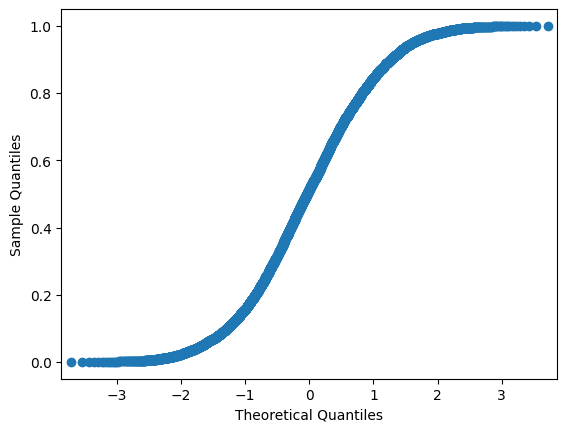

In [ ]:
import statsmodels.api as sm
import numpy as np


U = np.random.uniform(0, 1, 10000)
fig = sm.qqplot(U)

# Użytkownicy

In [ ]:
users.head()

,user_id,name,city,street,favourite_genres,premium_user,id
0,101,Dominik Paździora,Wrocław,aleja Jabłoniowa 55/02,"[dance pop, latin, hard rock]",False,NaN
1,102,Justyna Mszyca,Poznań,ul. Krótka 710,"[reggaeton, latin arena pop, modern rock]",False,NaN
2,103,Kornelia Witka,Gdynia,al. Kościuszki 587,"[rap, art rock, rock]",False,NaN
3,104,Jędrzej Kotala,Gdynia,pl. Kossaka 97/86,"[mexican pop, contemporary country, psychedeli...",False,NaN
4,105,Karol Kleban,Kraków,ul. Tulipanowa 861,"[rock, adult standards, permanent wave]",False,NaN


Użytkownicy nam są nie potrzebni, bo mamy zrobić playlistę proponowaną dla wszystkich, a nie dla danej grupy.

# Sesje

In [ ]:
sessions.head()

,session_id,timestamp,user_id,track_id,event_type
0,124,2023-03-25T20:09:20.374331,123.0,None,play
1,125,2023-03-26T07:54:17.376121,144.0,0ijhkvBpA7OBlY4clWSUZw,play
2,126,2023-03-26T05:10:33.134128,144.0,7kcG2nk2Y9O1VEIyfjQO9p,play
3,126,2023-03-26T05:11:03.555128,144.0,None,like
4,126,2023-03-26T05:13:57.387128,144.0,1PtL0YQRtq3qxDGUSwZPJ5,play


In [ ]:
sessions["event_type"].value_counts()

play            83785
skip            26356
advertisment    21784
like            21116
Name: event_type, dtype: int64

In [ ]:
sessions[sessions["event_type"] == "advertisment"]

,session_id,timestamp,user_id,track_id,event_type
8,127,2023-03-25T20:37:26.696781,182.0,None,advertisment
23,128,2023-03-26T14:12:59.821436,182.0,None,advertisment
25,128,2023-03-26T14:16:34.395436,182.0,None,advertisment
27,129,2023-03-26T04:28:50.198446,132.0,None,advertisment
32,129,2023-03-26T04:30:25.748446,132.0,None,advertisment
...,...,...,...,...,...
161156,27880,2024-03-24T03:02:27.312388,194.0,None,advertisment
161160,27881,2024-03-24T13:41:46.007330,194.0,None,advertisment
161165,27883,2024-03-24T04:29:10.063519,NaN,None,advertisment
161173,27883,2024-03-24T04:41:09.558519,197.0,None,advertisment


Jeżeli jest wyświetlana reklama to nie ma ona id utworu, dlatego też można w ogóle nie brać tego pod uwagę.

Reklam jest 21784.

In [ ]:
get_nulls(sessions)

Number of NaN in column user_id: 8021
Number of NaN in column track_id: 29922
Number of NaN in column event_type: 8153


Aż 8153 wierszy ma puste informacje dotyczące event_type, które są dosyć istotne, aby wiedzieć co dokładnie użytkownik zrobił podczas sesji.

8021 wierszy nie posiada informacji na temat id użytkownika. Nie korzystamy z tabeli użytkowników więc nie potrzebujemy tej danej. Brak jej może być jednak spowodowana błędem przez który mielibyśmy niepoprawne dane.

In [ ]:
nan_count = sessions["track_id"].isna().sum() - sessions[sessions["event_type"] == "advertisment"]["track_id"].isna().sum()
if nan_count:
    print(f'Number of NaN in column {"track_id"}: {nan_count}')

Number of NaN in column track_id: 8138


Nie biorąc pod uwagę reklam które nie posiadają informacji na temat utworu. 
8138 wierszy nie posiada informacji o tym jaki utwór jest odtwarzany. Tracimy więc najważniejszą informację z tej tabeli.

# Podsumowanie analizy

Po usunięciu danych błędnych oraz pustych mamy ponad 18 tysięcy utworów oraz 110 tysięcy sesji. Po zastosowaniu zadania rankingowania zostanie nam ponad 4.5 tysiąca utworów. Do grupowania będziemy używać 14 atrybutów, więc dane wydają się być wystarczające do rozwiązania zadania.

- biznesowe kryterium sukcesu powinno uwzględniać jakąś miarę jakości rozwiązania, przenieść analityczne do biznesowe

- czy jesteście Państwo pewni, że zmienne wejściowe niosą jakąś informację o zmiennej celu?, ocenienie rankingowania korelacja wskaźnika popularności i sesji

# Przetworzone dane

## Rankingowanie

## Grupowanie

In [89]:
prepared_data = pd.merge(tracks,artists, left_on="id_artist", right_on="id")
prepared_data = prepared_data.dropna()
prepared_data['autor_code'] = pd.Categorical(prepared_data['id_artist']).codes
prepared_data["release_date"] = pd.to_datetime(prepared_data["release_date"], format = "mixed")
prepared_data = prepared_data.drop(columns=["id_x", "name_x", "popularity", "id_artist", "id_y", "name_y"])

In [90]:
genres = pd.get_dummies(prepared_data['genres'].apply(pd.Series).stack()).groupby(level=0).sum()
prepared_data['genres'] = genres.apply(lambda row: ''.join(row.astype(str)), axis=1)

In [91]:
# przechowuje w kolumnach kolejne gatunki, 1 oznacza że dany autor danego utworu tworzy w danym gatunku
genres.head()

,a cappella,acid rock,acoustic pop,adult standards,afro dancehall,afrofuturism,afrofuturismo brasileiro,afropop,afroswing,alabama rap,...,welsh metal,west coast rap,women's music,world,world worship,worship,wrestling,yacht rock,zhongguo feng,zolo
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# połączony dataframe gatunków w jedną kolumnę
prepared_data['genres'].head()

0    0001000000000000000000000000000000000000000000...
1    0001000000000000000000000000000000000000000000...
3    0001000000000000000000000000000000000000000000...
5    0001000000000000000000000000000000000000000000...
6    0001000000000000000000000000000000000000000000...
Name: genres, dtype: object

In [95]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16438 entries, 0 to 20197
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   duration_ms       16438 non-null  int64         
 1   explicit          16438 non-null  int64         
 2   release_date      16438 non-null  datetime64[ns]
 3   danceability      16438 non-null  float64       
 4   energy            16438 non-null  float64       
 5   key               16438 non-null  int64         
 6   loudness          16438 non-null  float64       
 7   speechiness       16438 non-null  float64       
 8   acousticness      16438 non-null  float64       
 9   instrumentalness  16438 non-null  float64       
 10  liveness          16438 non-null  float64       
 11  valence           16438 non-null  float64       
 12  tempo             16438 non-null  float64       
 13  genres            16438 non-null  object        
 14  autor_code        16438 non

/home/tomwez/.local/lib/python3.12/site-packages/pandas/core/internals/managers.py:1753: RuntimeWarning: overflow encountered in cast
  result[rl.indexer] = arr


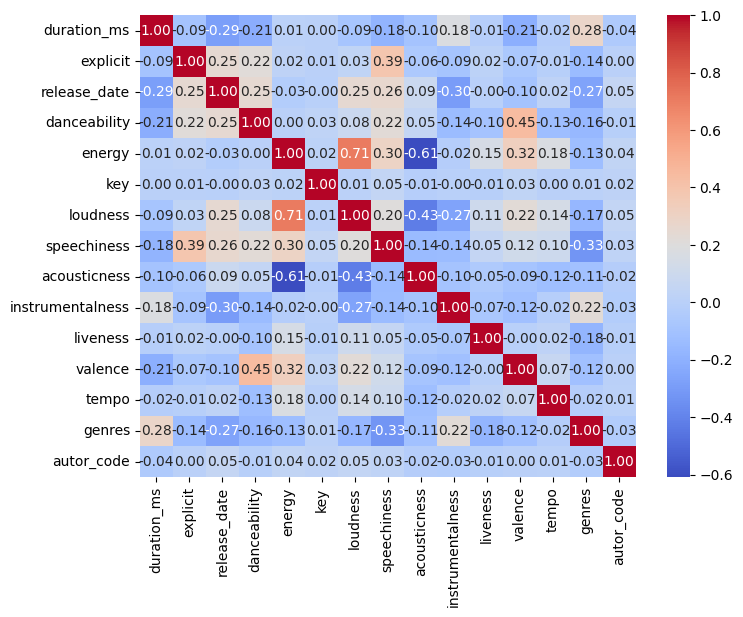

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

df_numeric = prepared_data.select_dtypes(exclude=['object'])
corr_matrix = prepared_data.corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Posiadamy 16438 danych do modelowania z 14 atrybutami.
Atrybuty te są ze sobą słabo skorelowane co...